In [4]:
import torch
from torch import nn
from torchvision.transforms import ToTensor
import numpy as np
from PIL import Image, ImageDraw
import os
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, VBox, interact, fixed
import ipywidgets
import matplotlib.pyplot as plt
import napari
from napari.utils.translations import trans
from io import BytesIO

In [2]:
def rotate_3d_tensor(tensor, angle_x=0.0, angle_y=0.0, angle_z=0.0):
    """
    Apply a 3D rotation to a PyTorch tensor using rotation matrices.

    Parameters:
    - tensor: torch.Tensor of shape (N, 3) representing N points in 3D space.
    - angle_x: Rotation angle around the X-axis in radians.
    - angle_y: Rotation angle around the Y-axis in radians.
    - angle_z: Rotation angle around the Z-axis in radians.

    Returns:
    - Rotated tensor of shape (N, 3).
    """


    # Rotation matrix around X-axis
    Rx = torch.tensor(np.array([
        [1, 0, 0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x), np.cos(angle_x)]
    ]), dtype=tensor.dtype, device=tensor.device)

    # Rotation matrix around Y-axis
    Ry = torch.tensor(np.array([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0, 1, 0],
        [-np.sin(angle_y), 0, np.cos(angle_y)]
    ]), dtype=tensor.dtype, device=tensor.device)

    # Rotation matrix around Z-axis
    Rz = torch.tensor(np.array([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z), np.cos(angle_z), 0],
        [0, 0, 1]
    ]), dtype=tensor.dtype, device=tensor.device)

    # Compute the combined rotation matrix
    R = Rz @ Ry @ Rx  # Apply rotations in order: X -> Y -> Z

    # Apply the rotation
    rotated_tensor = tensor @ R.T  # Transpose because torch.matmul assumes row vectors

    return rotated_tensor

def create_3d_grid(x_range, y_range, z_range, resolution):
    """
    Create a 2D grid with specified x and y ranges and resolution.

    Parameters:
    x_range (tuple): (min_x, max_x)
    y_range (tuple): (min_y, max_y)
    resolution (tuple): (x_resolution, y_resolution)

    Returns:
    np.ndarray: 2D grid as an (N, 2) array where each row is an [x, y] pair.
    """
    x_min, x_max = x_range
    y_min, y_max = y_range
    z_min, z_max = z_range

    x_res, y_res, z_res = resolution

    x_values = np.linspace(x_min, x_max, x_res, dtype=int)
    y_values = np.linspace(y_min, y_max, y_res, dtype=int)
    z_values = np.linspace(z_min, z_max, z_res, dtype=int)

    
    x_grid, y_grid, z_grid = np.meshgrid(x_values, y_values, z_values)
    grid = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()]).T
    
    
    return grid


In [6]:
bloc = torch.rand((500,500,500,3), device='cpu')

In [7]:
viewer = napari.Viewer(ndisplay=3)
image_layer = viewer.add_image(
    bloc, rendering='mip', name='volume', blending='additive', opacity=0.25
)

plane_parameters = {
    'position': (32, 32, 32),
    'normal': (0, 1, 0),
    'thickness': 10,
}

plane_layer = viewer.add_image(
    bloc,
    rendering='average',
    name='plane',
    depiction='plane',
    blending='additive',
    opacity=0.5,
    plane=plane_parameters
)

viewer.axes.visible = True
viewer.camera.angles = (45, 45, 45)
viewer.camera.zoom = 5
viewer.text_overlay.text = trans._(
    """
shift + click and drag to move the plane
press 'x', 'y' or 'z' to orient the plane along that axis around the cursor
press 'o' to orient the plane normal along the camera view direction
press and hold 'o' then click and drag to make the plane normal follow the camera
"""
)
viewer.text_overlay.visible = True
napari.run()


---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File c:\Users\anthony\anaconda3\envs\torch\Lib\site-packages\napari\_qt\threads\status_checker.py:114, in StatusChecker.calculate_status(self=<napari._qt.threads.status_checker.StatusChecker object>)
    110     return
    112 try:
    113     # Calculate the status change from cursor's movement
--> 114     res = viewer._calc_status_from_cursor()
        viewer = Viewer(camera=Camera(center=(249.5, 249.5, 249.5), zoom=np.float64(1.1381), angles=(np.float64(6.564461420189845), np.float64(-32.21338640238001), np.float64(57.56708598233277)), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(np.float64(419.0932882872596), np.float64(478.0717065858616), np.float64(-28.892401486275972)), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=3, order=(2, 0, 1), axis_labels=('0', '

In [31]:
x_values = np.linspace(0, 499, 500)
y_values = np.linspace(0, 499, 500)
z_values = np.array([0]*500)

x_grid, y_grid, z_grid = np.meshgrid(x_values, y_values, z_values)
grid = np.vstack([x_grid.ravel(), y_grid.ravel(), z_grid.ravel()]).T

In [32]:
def slicer(bloc,grid, theta_x=0,theta_y=0,theta_z=0):
    
    grid_r = rotate_3d_tensor(torch.tensor(grid,device='cuda', dtype=torch.float), theta_x, theta_y, theta_z)
    grid_r = grid_r.to(torch.int)
    xs = grid_r[:,0]
    ys = grid_r[:,1]
    zs = grid_r[:,2]
    img = bloc[[xs,ys,zs]]
    img = img.reshape(500,500,500,3)
    img = img[:,:,0,:]
    plt.imshow(img.cpu())


In [33]:
interact(slicer, bloc=fixed(bloc), grid=fixed(grid), theta_x=(0,2*np.pi,0.1), theta_y=(0,2*np.pi,0.1), theta_z=(0,2*np.pi,0.1))

interactive(children=(FloatSlider(value=0.0, description='theta_x', max=6.283185307179586), FloatSlider(value=…

<function __main__.slicer(bloc, grid, theta_x=0, theta_y=0, theta_z=0)>

In [22]:
grid_r = rotate_3d_tensor(torch.tensor(grid,device='cuda', dtype=torch.float), 0, -np.pi/4)

In [23]:
grid_r = grid_r.to(torch.int)

In [24]:
xs = grid_r[:,0]
ys = grid_r[:,1]
zs = grid_r[:,2]


In [25]:
img = bloc[[xs,ys,zs]]

In [9]:
img = img.reshape(500,500,500,3)

In [10]:
img = img[:,:,0,:]

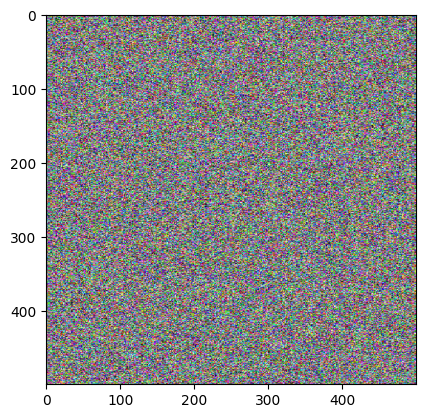

In [12]:
plt.imshow(img.cpu())